# **CS4120 Final Project - Vinit Patel**

## 1. Data Display + Preprocessing

In [1]:
import re
import numpy as np
import pandas as pd

### 1.1 Loading Data

In [2]:
df_train = pd.read_csv('data/train.txt', names=['text', 'emotion'], sep=';')
df_val = pd.read_csv('data/val.txt', names=['text', 'emotion'], sep=';')
df_test = pd.read_csv('data/test.txt', names=['text', 'emotion'], sep=';')

In [3]:
# combining the data files b/c they are not that big individually.
df = pd.concat([df_train, df_val, df_test])
df.head()

,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


### 1.2 Examining Data

In [4]:
# checking the shape of our data - 20,000 values
df.shape

(20000, 2)

In [5]:
# checking for null values
df.isnull().sum()

text       0
emotion    0
dtype: int64

In [6]:
# checking for duplicates since we combined the datasets
df.duplicated().sum()

1

In [7]:
# dropping the duplicate - inplace=True ensures we don't create a whole new copy
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19999 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     19999 non-null  object
 1   emotion  19999 non-null  object
dtypes: object(2)
memory usage: 468.7+ KB


### 1.3 Data Visualization
##### Making representations of the data for better understanding and emphasis

In [8]:
# imports for graphs/plots

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

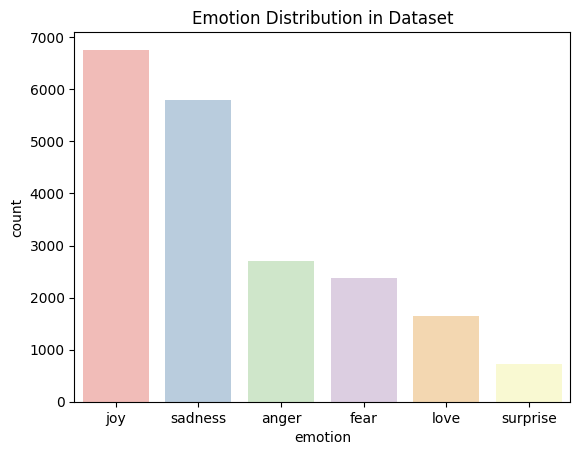

In [9]:
# displayiong how many of each emotion is present in the data
sns.countplot(x='emotion', data=df, order=df['emotion'].value_counts().index, palette='Pastel1')
plt.title('Emotion Distribution in Dataset')
plt.show()

In [10]:
df['length'] = df['text'].apply(len)
desc = df['length'].describe()
desc

count    19999.000000
mean        96.671784
std         55.778779
min          7.000000
25%         53.000000
50%         86.000000
75%        129.000000
max        300.000000
Name: length, dtype: float64

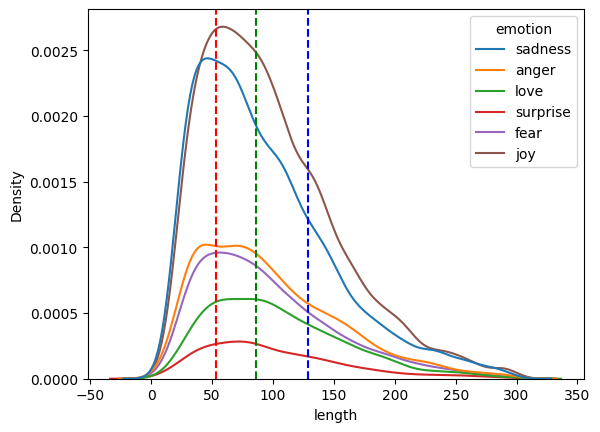

In [11]:
fig = plt.figure()
sns.kdeplot(x=df['length'], hue=df['emotion'])
plt.axvline(desc['25%'], color='r', linestyle='--', label='25%')
plt.axvline(desc['50%'], color='g', linestyle='--', label='Median')
plt.axvline(desc['75%'], color='b', linestyle='--', label='75%')
plt.show()


Above is a kde plot of the lengths of the data entries colored by emotion.
I've also drawn lines along the x-axis that show the 25th, 50th (median), and 75th
percentile of the length.

75% of the values are below 129 (according to the summary from the previous cells), while the max is 300. 


In [12]:
# creating wordclouds - found a tutorial in the matplotlib doc and thought it would be a nice visual

# necessary imports
import nltk

# prepping the lemmatizer and stopwords
lemmatizer = nltk.stem.WordNetLemmatizer()
stopwords = set(nltk.corpus.stopwords.words('english'))

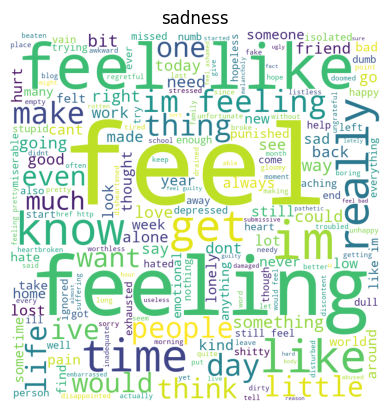

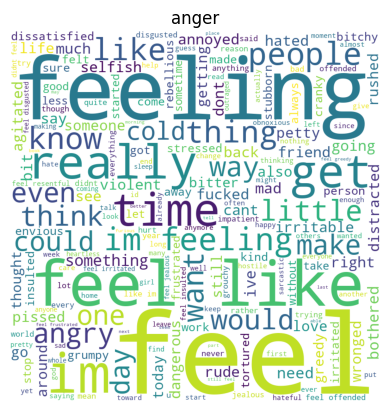

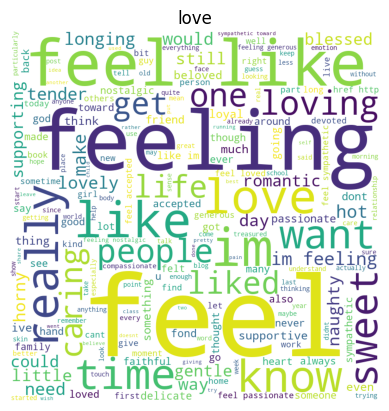

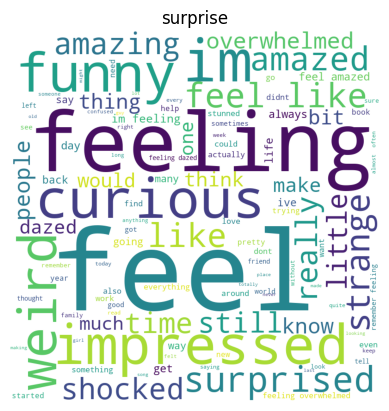

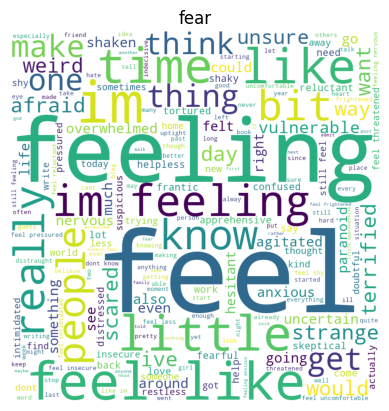

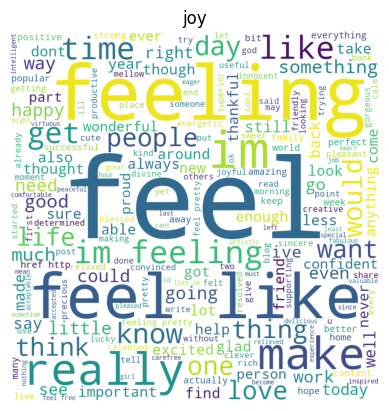

In [13]:
emotions = df['emotion'].unique()
for emotion in emotions:
    text = " ".join(df[df['emotion'] == emotion]['text'])
    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(text)
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.title(emotion)
    plt.show()

### 1.4 Text Preprocessing

In [14]:
# defining a function that will process the text element of the df
def preprocess(text):
    tokens = nltk.word_tokenize(text.lower())
    filtered_tokens = [lemmatizer.lemmatize(token) for token in tokens if token.lower() not in stopwords and token.isalnum()]
    return " ".join(filtered_tokens)

In [15]:
df['processed_text'] = df["text"].apply(preprocess)
df.head()

,text,emotion,length,processed_text
0,i didnt feel humiliated,sadness,23,didnt feel humiliated
1,i can go from feeling so hopeless to so damned...,sadness,108,go feeling hopeless damned hopeful around some...
2,im grabbing a minute to post i feel greedy wrong,anger,48,im grabbing minute post feel greedy wrong
3,i am ever feeling nostalgic about the fireplac...,love,92,ever feeling nostalgic fireplace know still pr...
4,i am feeling grouchy,anger,20,feeling grouchy


In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df["text"], df["emotion"],
                                                    test_size=0.2, random_state=42)

## 2. Models

### 2.1 Logistic Regression

In [17]:
# imports for LR
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [18]:
# converting data to tf-idf vectors
tfidf = TfidfVectorizer(max_features=5000)
X_train_tf = tfidf.fit_transform(X_train)
X_test_tf = tfidf.transform(X_test)

In [19]:
# training the lr model
lr_model = LogisticRegression(max_iter=10000)
lr_model.fit(X_train_tf, y_train)

LogisticRegression(max_iter=10000)

In [20]:
lr_pred = lr_model.predict(X_test_tf)
lr_accuracy = accuracy_score(y_test, lr_pred)
print("LR Accuracy", lr_accuracy)
print("Classification Report:")
print(classification_report(y_test, lr_pred))

LR Accuracy 0.8715
Classification Report:
              precision    recall  f1-score   support

       anger       0.91      0.82      0.86       537
        fear       0.84      0.75      0.79       441
         joy       0.84      0.96      0.90      1334
        love       0.89      0.66      0.76       330
     sadness       0.90      0.95      0.92      1203
    surprise       0.86      0.47      0.61       155

    accuracy                           0.87      4000
   macro avg       0.87      0.77      0.81      4000
weighted avg       0.87      0.87      0.87      4000



LR Confusion Matrix:


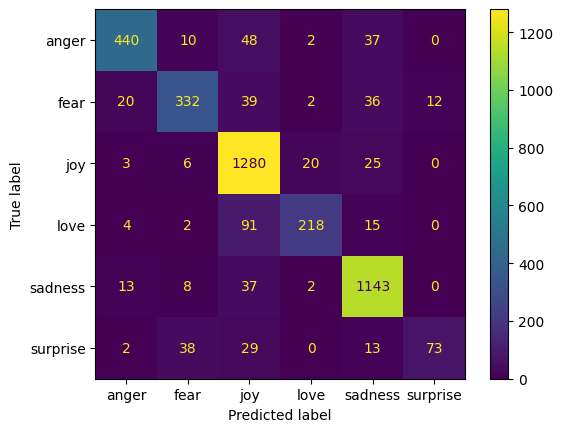

In [21]:
lr_cm = confusion_matrix(y_test, lr_pred)
print("LR Confusion Matrix:")
disp_lr = ConfusionMatrixDisplay(confusion_matrix=lr_cm, display_labels=lr_model.classes_)
disp_lr.plot()
plt.show()

### 2.2 LSTM

In [22]:
# imports for LSTM

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder

In [23]:
# tokenizing
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['processed_text'])
X = tokenizer.texts_to_sequences(df['processed_text']) 
max_length = max([len(x) for x in X])
X = pad_sequences(X, maxlen=max_length)

vocabsize = len(tokenizer.index_word) + 1
lstm_output_dim = 128

In [24]:
# encoding labels
label_encoder_lstm = LabelEncoder()
y = label_encoder_lstm.fit_transform(df['emotion'])

In [25]:
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X, y, test_size=0.2, random_state=42)

# X_train_lstm.size

In [26]:
# building LSTM model
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=vocabsize, output_dim=lstm_output_dim))
lstm_model.add(Dropout(0.25))
lstm_model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(Dense(len(label_encoder_lstm.classes_), activation='softmax'))

lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [27]:
# training the LSTM
history = lstm_model.fit(X_train_lstm, y_train_lstm, epochs = 5, batch_size=64, validation_split=0.1, 
                         callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

Epoch 1/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.3734 - loss: 1.5507 - val_accuracy: 0.7444 - val_loss: 0.7616
Epoch 2/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.8418 - loss: 0.5017 - val_accuracy: 0.8994 - val_loss: 0.2918
Epoch 3/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.9509 - loss: 0.1483 - val_accuracy: 0.9031 - val_loss: 0.2549
Epoch 4/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.9715 - loss: 0.0882 - val_accuracy: 0.9094 - val_loss: 0.2575
Epoch 5/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.9756 - loss: 0.0657 - val_accuracy: 0.9087 - val_loss: 0.2693


In [28]:
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test_lstm, y_test_lstm)
print("LSTM Accuracy:", lstm_accuracy)
print("LSTM Loss:", lstm_loss)

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9221 - loss: 0.2270
LSTM Accuracy: 0.9160000085830688
LSTM Loss: 0.24235357344150543


In [29]:
# an lstm returns probabilities instead of labels, so we need some adjustments for the confusion matrix
lstm_pred = lstm_model.predict(X_test_lstm)
# getting the labels with numpy
lstm_pred_labels = np.argmax(lstm_pred, axis=1)
# a Sequential object doesn't have 'classes' so we'll identify each label here, and I'll label them 
# below the confusion matrix according to the emotion
unique_labels = np.unique(y_test_lstm)

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [30]:
# Convert unique labels to list of strings
unique_labels_str = [str(label) for label in unique_labels]

# Generate classification report
print("LSTM Classification Report:")
print(classification_report(y_test_lstm, lstm_pred_labels, target_names=unique_labels_str))


LSTM Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       537
           1       0.87      0.81      0.84       441
           2       0.94      0.94      0.94      1334
           3       0.83      0.85      0.84       330
           4       0.94      0.97      0.96      1203
           5       0.74      0.79      0.76       155

    accuracy                           0.92      4000
   macro avg       0.88      0.88      0.88      4000
weighted avg       0.92      0.92      0.92      4000



LSTM Confusion Matrix:


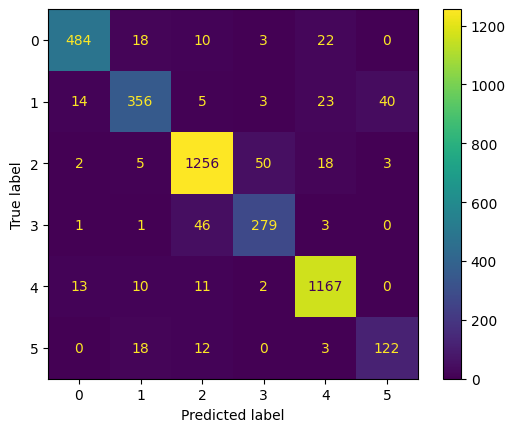

In [31]:
lstm_cm = confusion_matrix(y_test_lstm, lstm_pred_labels)
print("LSTM Confusion Matrix:")
disp_lstm = ConfusionMatrixDisplay(confusion_matrix=lstm_cm, display_labels=unique_labels)
disp_lstm.plot()
plt.show()

#### **0 = anger | 1 = fear  | 2 = joy | 3 = love | 4 = sadness | 5 = surprise**

### 2.3 Transformer-Based Model - BERT

In [32]:
# necessary imports
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, DistilBertConfig, AdamW
import torch
from tqdm.notebook import tqdm_notebook
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [33]:
# defining our distilbert tokenizer
btokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [34]:
# splitting data into train, test, and val sets
# using 60% of the data for training, 20% for val, and 20% for test

# splitting into train and temp
X_train, X_temp, y_train, y_temp = train_test_split(df["processed_text"], df["emotion"], test_size=0.4, random_state=42)
# splitting into val and test from temp
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# emotions -> label encodings
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

In [35]:
# tokenizing and encoding
train_tokenized_texts = [btokenizer.tokenize(text) for text in X_train]
val_tokenized_texts = [btokenizer.tokenize(text) for text in X_val]
test_tokenized_texts = [btokenizer.tokenize(text) for text in X_test]

train_input_ids = [btokenizer.convert_tokens_to_ids(tokens) for tokens in train_tokenized_texts]
val_input_ids = [btokenizer.convert_tokens_to_ids(tokens) for tokens in val_tokenized_texts]
test_input_ids = [btokenizer.convert_tokens_to_ids(tokens) for tokens in test_tokenized_texts]

# padding sequences to the same length
train_input_ids = pad_sequences(train_input_ids, maxlen=max_length, dtype="long", truncating="post", padding="post")
val_input_ids = pad_sequences(val_input_ids, maxlen=max_length, dtype="long", truncating="post", padding="post")
test_input_ids = pad_sequences(test_input_ids, maxlen=max_length, dtype="long", truncating="post", padding="post")

train_input_ids = torch.tensor(train_input_ids)
val_input_ids = torch.tensor(val_input_ids)
test_input_ids = torch.tensor(test_input_ids)

In [36]:
# creating the attention masks off a simple implementation
train_attention_masks = [[float(i > 0) for i in seq] for seq in train_input_ids]
val_attention_masks = [[float(i > 0) for i in seq] for seq in val_input_ids]
test_attention_masks = [[float(i > 0) for i in seq] for seq in test_input_ids]

train_attention_masks = torch.tensor(train_attention_masks)
val_attention_masks = torch.tensor(val_attention_masks)
test_attention_masks = torch.tensor(test_attention_masks)

In [37]:
# defining datasets for train, val, and test
train_dataset = TensorDataset(train_input_ids, train_attention_masks, torch.tensor(y_train_encoded))
val_dataset = TensorDataset(val_input_ids, val_attention_masks, torch.tensor(y_val_encoded))
test_dataset = TensorDataset(test_input_ids, test_attention_masks, torch.tensor(y_test_encoded))

In [38]:
# setting device to cpu b/c i do not have a gpu :/
# found a way to use a gpu if one is available for other people who may run this
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [43]:
# creating a range of hyperparams we want to explore
# better alternative to my original approach

learning_rates = [2e-5, 5e-5]
# originally used 32, added 16 to see if lower batch size resulted in better performance
# lower than that isn't very manageable on my laptop
batch_sizes = [16, 32]
# using 2, 3, and 5 epochs like prof Mai suggested
epochs_list = [2, 3, 5]

best_val_accuracy = 0.0
best_hyperparameters = {}

In [42]:
# originally tuned hyperparams baed on val_loss
# changed it to val_accuracy since it's more meaningful in classification tasks
for lr in learning_rates:
    for batch_size in batch_sizes:
        for num_epochs in epochs_list:
            print(f"Hyperparameters: Learning Rate={lr}, Batch Size={batch_size}, Epochs={num_epochs}")

            # defining datasets & dataloaders for train val and test sets
            train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
            val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch_size)
            test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)

            # defining our model and optimizer based on current hyperparameters
            model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(df['emotion'].unique()))
            optimizer = AdamW(model.parameters(), lr=lr)
            model.to(device)

            # defining a validation loop using eval
            model.eval()
            total_correct = 0
            total_samples = 0
            progress_bar_val = tqdm_notebook(val_dataloader, desc=f"Validation")
            with torch.no_grad():
                for batch in progress_bar_val:
                    batch = tuple(t.to(device) for t in batch)
                    b_input_ids, b_input_mask, b_labels = batch
                    outputs = model(b_input_ids, attention_mask=b_input_mask)
                    logits = outputs.logits
                    preds = torch.argmax(logits, dim=1)
                    total_correct += (preds == b_labels).sum().item()
                    total_samples += b_labels.size(0)
            val_accuracy = total_correct / total_samples

            print(f'Validation Accuracy: {val_accuracy}')

            # updating which hyperparams we consider the best based on accuracy
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                best_hyperparameters = {'learning_rate': lr, 'batch_size': batch_size, 'epochs': num_epochs}

# printing the best combination we found
print("Best hyperparameters:", best_hyperparameters)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Hyperparameters: Learning Rate=2e-05, Batch Size=16, Epochs=2


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Validation Accuracy: 0.21125
Hyperparameters: Learning Rate=2e-05, Batch Size=16, Epochs=3


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Validation Accuracy: 0.15525
Hyperparameters: Learning Rate=2e-05, Batch Size=16, Epochs=5


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Validation Accuracy: 0.145
Hyperparameters: Learning Rate=2e-05, Batch Size=32, Epochs=2


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Accuracy: 0.091
Hyperparameters: Learning Rate=2e-05, Batch Size=32, Epochs=3


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Accuracy: 0.1165
Hyperparameters: Learning Rate=2e-05, Batch Size=32, Epochs=5


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation:   0%|          | 0/125 [00:00<?, ?it/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Accuracy: 0.112
Hyperparameters: Learning Rate=5e-05, Batch Size=16, Epochs=2


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Validation Accuracy: 0.27775
Hyperparameters: Learning Rate=5e-05, Batch Size=16, Epochs=3


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Validation Accuracy: 0.13725
Hyperparameters: Learning Rate=5e-05, Batch Size=16, Epochs=5


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Validation Accuracy: 0.05025
Hyperparameters: Learning Rate=5e-05, Batch Size=32, Epochs=2


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Accuracy: 0.3
Hyperparameters: Learning Rate=5e-05, Batch Size=32, Epochs=3


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Accuracy: 0.12425
Hyperparameters: Learning Rate=5e-05, Batch Size=32, Epochs=5


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Accuracy: 0.1465
Best hyperparameters: {'learning_rate': 5e-05, 'batch_size': 32, 'epochs': 2}


### Best Hyperparameters
#### Learning Rate: 5e-5, Batch Size: 32, Epochs: 2

In [46]:
# storing the values of the best hyperparams
best_learning_rate = best_hyperparameters['learning_rate']
best_batch_size = best_hyperparameters['batch_size']
best_epochs = best_hyperparameters['epochs']

# defining datasets and dataloaders using the new hyperparams
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=best_batch_size)
val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=best_batch_size)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=best_batch_size)

In [47]:
# defining a model, optimizer, etc. using the hyperparams we found to be best
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(df['emotion'].unique()))
optimizer = AdamW(model.parameters(), lr=best_learning_rate)
model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [48]:
# defining a training loop
for epoch in range(best_epochs):
    # training
    model.train()
    total_train_loss = 0
    # tqdm progress bar just to keep track of time
    progress_bar_train = tqdm_notebook(train_dataloader, desc=f"Epoch {epoch+1}/{best_epochs} Training")
    for batch in progress_bar_train:
        # forward pass
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels.long())
        loss = outputs.loss
        # backward pass
        loss.backward()
        # updates params
        optimizer.step()
        total_train_loss += loss.item()
        # updating the tqdm progress bar
        progress_bar_train.set_postfix({'train_loss': loss.item()})
    avg_train_loss = total_train_loss / len(train_dataloader)

    print(f'Epoch {epoch+1}/{best_epochs}, Train Loss: {avg_train_loss}')

# saving the trained
torch.save(model.state_dict(), 'bert_model.pth')

Epoch 1/2 Training:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 1/2, Train Loss: 0.6644611304799716


Epoch 2/2 Training:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 2/2, Train Loss: 0.1788127820144097


In [49]:
# Load the best model for evaluation
model.load_state_dict(torch.load('bert_model.pth'))

<All keys matched successfully>

In [50]:
# evaluating the model on the test set now
model.eval()
test_predictions = []
test_true_labels = []

progress_bar_test = tqdm_notebook(test_dataloader, desc="Evaluating on Test Set")
for batch in progress_bar_test:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        outputs = model(b_input_ids, attention_mask=b_input_mask)
    logits = outputs.logits
    preds = torch.argmax(logits, dim=1).cpu().numpy()
    test_predictions.extend(preds)
    test_true_labels.extend(b_labels.cpu().numpy())


Evaluating on Test Set:   0%|          | 0/125 [00:00<?, ?it/s]

In [51]:
# calculating accuracy
test_accuracy = accuracy_score(test_true_labels, test_predictions)
print("Test Accuracy:", test_accuracy)

# printing a classification report for further details
print("Classification Report:")
print(classification_report(test_true_labels, test_predictions))

Test Accuracy: 0.927
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.94       532
           1       0.87      0.89      0.88       426
           2       0.94      0.95      0.95      1388
           3       0.81      0.83      0.82       318
           4       0.98      0.95      0.96      1193
           5       0.88      0.70      0.78       143

    accuracy                           0.93      4000
   macro avg       0.90      0.88      0.89      4000
weighted avg       0.93      0.93      0.93      4000



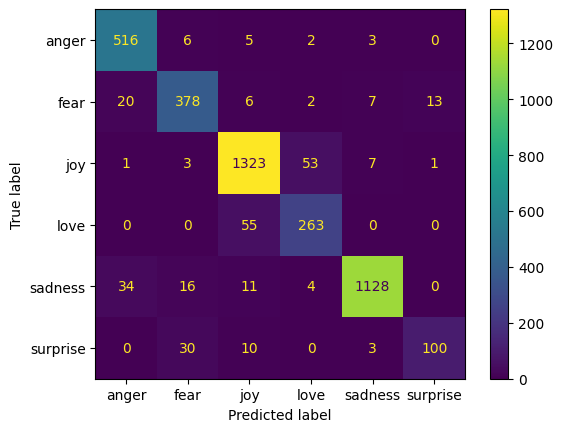

In [52]:
# creating a confusion matrix
test_cm = confusion_matrix(test_true_labels, test_predictions)
test_disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=label_encoder.classes_)
test_disp.plot()
plt.show()